In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Put 12 Months in One File

In [2]:
#12 months of data into a signle file
from os import listdir
from os.path import isfile, join

mypath='./Sales_Data/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
all_months_data=pd.DataFrame()
lines=0

myorder=[8,2,3,1,5,11,10,4,9,7,6,0]
ordered_months = files
ordered_months = [ordered_months[i] for i in myorder]

for i in ordered_months:
    temp_=pd.read_csv(mypath+i)
    all_months_data=pd.concat([all_months_data,temp_])
    lines=lines+(temp_.count())
    
all_months_data.to_csv('all_data.csv',index=False)

In [3]:
all_data=pd.read_csv('all_data.csv')

### Best Month for Sales? Earnigns?

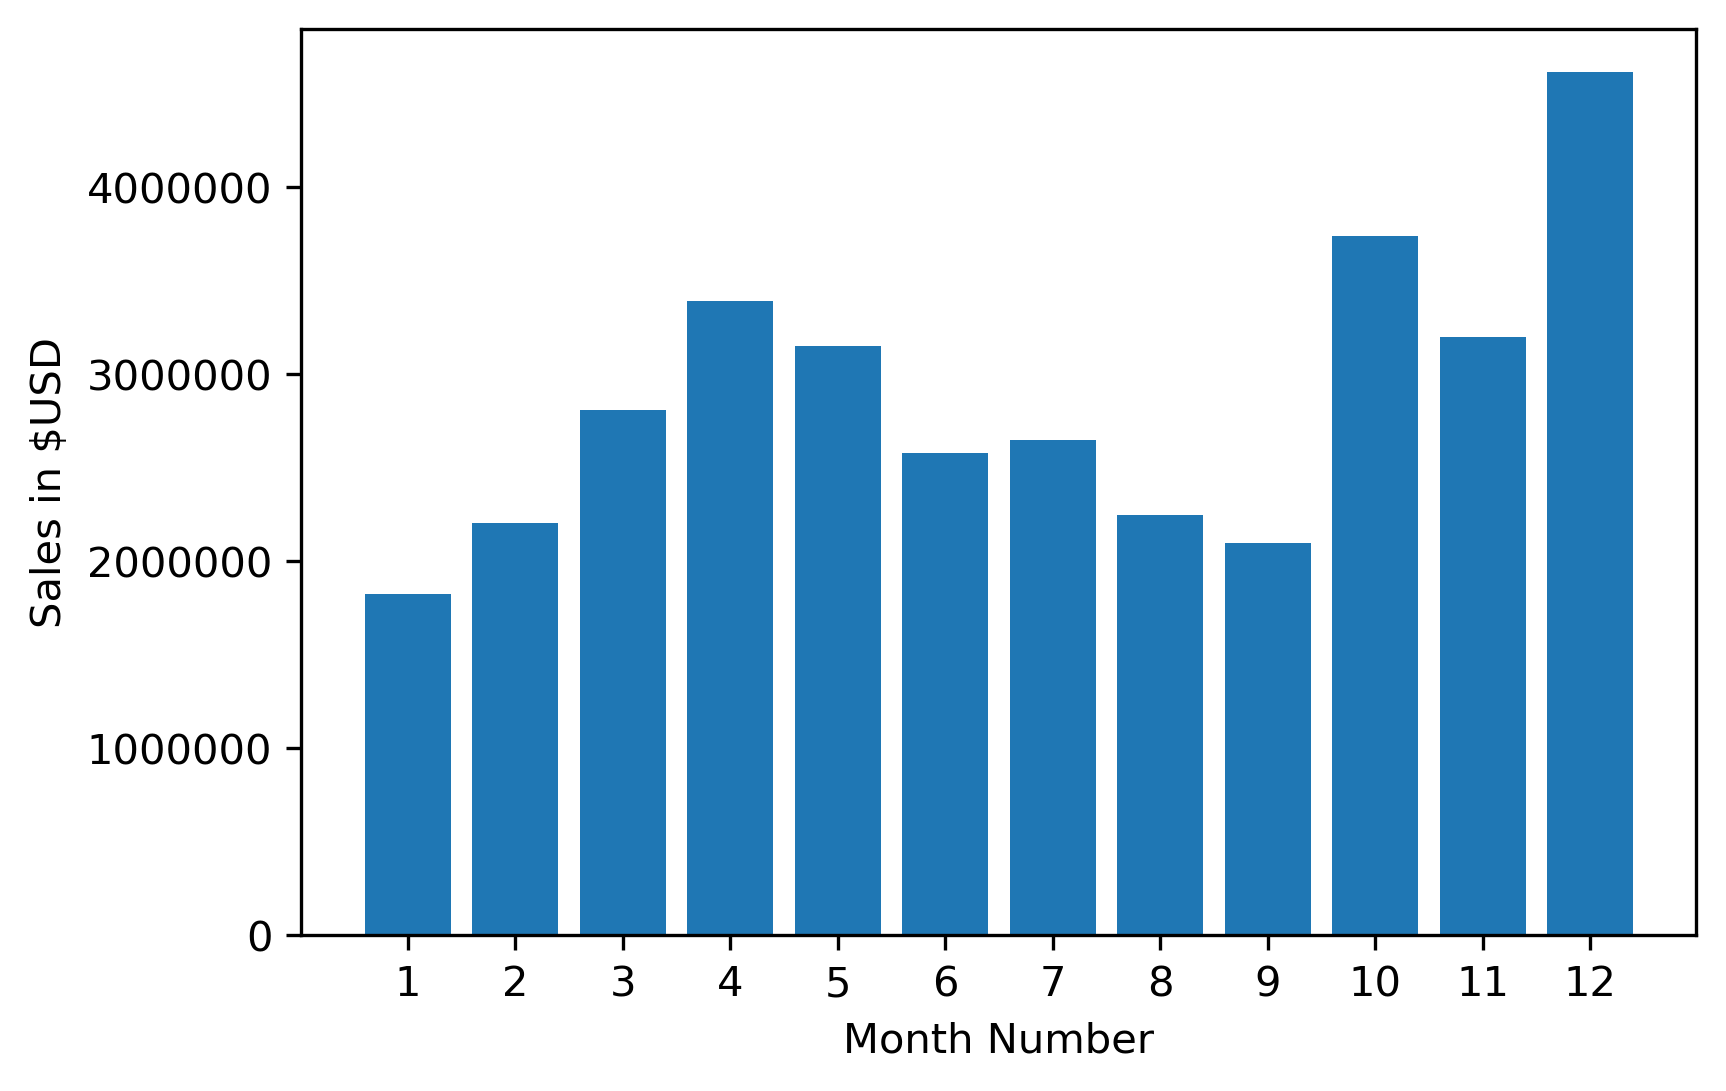

In [4]:
# Clean Data from NAN
# Drop all rows with NAN
nan_df=all_data[all_data.isna().any(axis=1)]
all_data=all_data.dropna(how='any') # any:for any singe nan , all: for whole rows of NaN

# Remove weird Or Error
all_data=all_data[all_data['Order Date'].str[0:2]!='Or']

# Create Month Column
all_data['Month'] = all_data['Order Date'].str[0:2]
all_data['Month'] = all_data['Month'].astype('int32')
all_data.head()

# Create Sales Column
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']
all_data.head()

# Sum of each month
month_sales_sum=all_data.groupby('Month').sum()

# Visualize
months=range(1,13)
plt.figure(figsize=(6,4),dpi=300)
plt.bar(months,month_sales_sum['Sales'])
plt.xticks(months)
plt.ylabel('Sales in $USD')
plt.xlabel('Month Number')

plt.show()

### City with highest number of sales

In [5]:
all_data['Purchase Address'].head()

0          944 Walnut St, Boston, MA 02215
1         185 Maple St, Portland, OR 97035
2    538 Adams St, San Francisco, CA 94016
3       738 10th St, Los Angeles, CA 90001
4            387 10th St, Austin, TX 73301
Name: Purchase Address, dtype: object

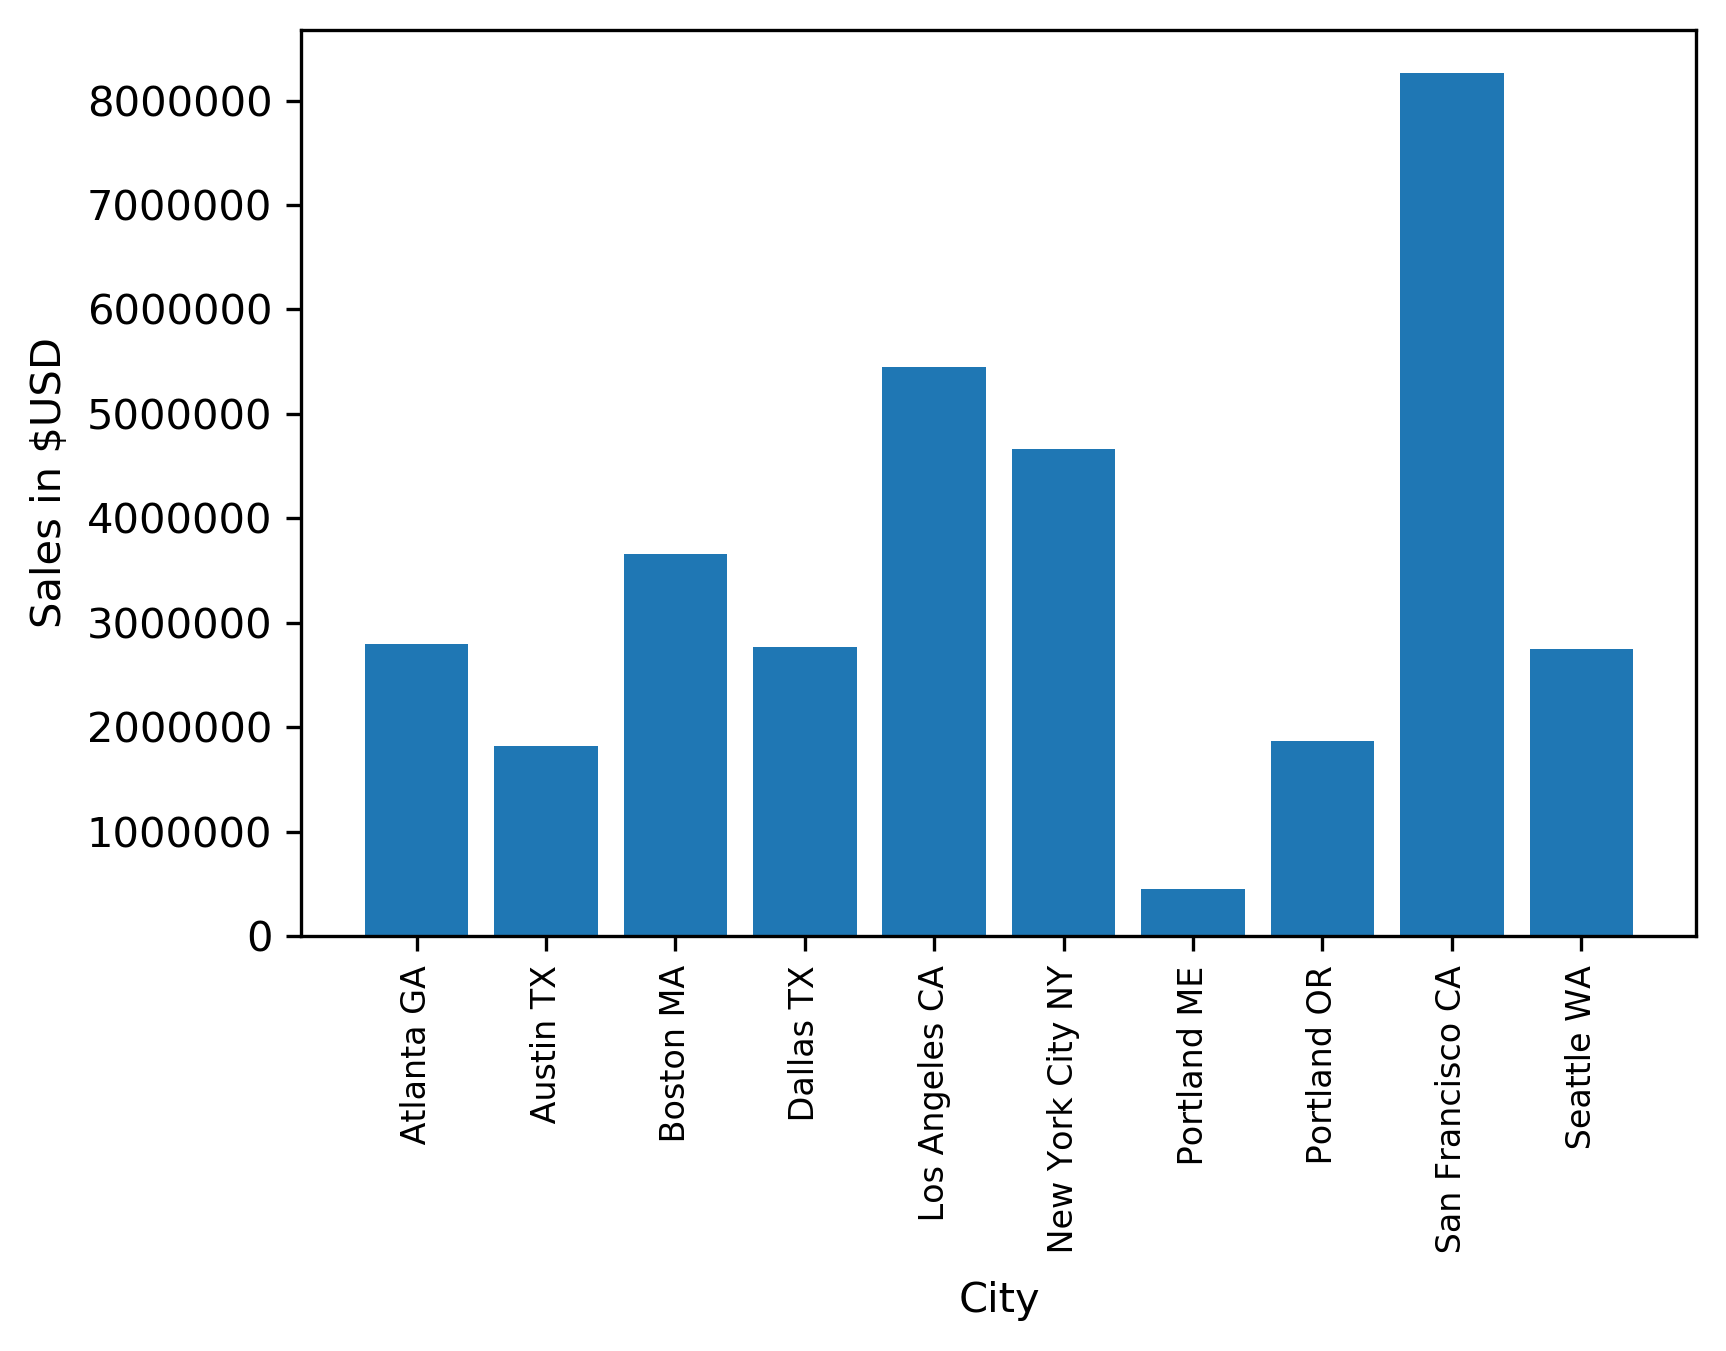

In [24]:
# Create City Column
# .apply insane, apply any function
def get_city_state(address,qq):
    if qq==1:
        return address.split(',')[1]
    else:
         return address.split(',')[2].split(' ')[1]
# Create City State Column
all_data['State'] = all_data['Purchase Address'].apply(lambda x: get_city_state(x,1)+' '+get_city_state(x,2))

# Sum of each month
city_sales_sum=all_data.groupby('State').sum()

# Visualize
cities=[ city for city, df in all_data.groupby('State')]

plt.figure(figsize=(6,4),dpi=300)
plt.bar(cities,city_sales_sum['Sales'])
plt.xticks(cities,rotation='vertical',size=8)
plt.ylabel('Sales in $USD')
plt.xlabel('City')

plt.show()

### Optimal Ad Timing

In [ ]:
# Add hour column
all_data['Hour'] = pd.to_datetime(all_data['Order Date']).dt.hour
all_data['Minute'] = pd.to_datetime(all_data['Order Date']).dt.minute
all_data['Count'] = 1
all_data.head()


In [ ]:
keys = [pair for pair, df in all_data.groupby(['Hour'])]

In [ ]:
plt.plot(keys, all_data.groupby(['Hour']).count()['Count'])
plt.xticks(keys)
plt.grid()
plt.show()
